# Overview

Goal: Can we predict a user's rating for a movie better than by giving the average rating?

Method:
1. Find the most-rated movie (to maximize the data)
2. Isolate the list of users who have rated this movie
3. Split this user list into a training/test group
4. Cluster users based on their ratings for other movies and find the average rating for the most-rated movie for each cluster
5. Determine where the test users fit in these clusters, predict that their rating for the movie will be the average of their cluster
6. Compare these predicted ratings vs. their true rating to the default prediction vs. true rating (the default prediction is that all users would rate it as the total average rating for that movie)

In [137]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
%matplotlib inline
import matplotlib.pyplot as plt

movies = pd.read_csv('./movielens/movies.csv', sep=',')
ratings = pd.read_csv('./movielens/ratings.csv', sep=',')
del ratings["timestamp"]

In [138]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [139]:
ratings.head()

,userId,movieId,rating
0,1,2,3.5
1,1,29,3.5
2,1,32,3.5
3,1,47,3.5
4,1,50,3.5


In [140]:
ratings["rating"].isnull().any()

False

All of the reviews are filled in! Yay!

# Step 1: Find the most-rated movie (to maximize the data)


In [141]:
ratingCounts=ratings["movieId"].value_counts()
ratingCounts.head()

296    67310
356    66172
318    63366
593    63299
480    59715
Name: movieId, dtype: int64

The most-rated movie is movieId 296, with 67,310 reviews.

In [142]:
mId = 296

In [143]:
movies[movies["movieId"] == mId]

,movieId,title,genres
293,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller


MovieId 296 is Pulp Fiction. Makes sense!

# Step 2: 2. Isolate the list of users who have rated this movie

In [144]:
ratingsOfInterest = ratings[ratings["movieId"]==mId]
ratingsOfInterest.count()

userId     67310
movieId    67310
rating     67310
dtype: int64

In [145]:
len(ratingsOfInterest["userId"].unique().tolist())/len(ratings["userId"].unique().tolist())*100

48.60173438368726

As expected, there are 67,310 reviews for this movie. 48% of all reviewers rated this movie!

In [146]:
ratingsOfInterest.head()

,userId,movieId,rating
11,1,296,4.0
845,8,296,5.0
983,11,296,3.5
1525,13,296,5.0
1821,15,296,3.0


In [147]:
users = ratingsOfInterest["userId"].unique().tolist()
len(users)

67310

There are 67,310 users in my list, which means that no one did more than one review.

# Step 3: Split this user list into a training/test group

I will break the 67,310 users into a 70-30 split

In [148]:
trainingProp = 0.7
testProp = 1-trainingProp

print("training: ", int(len(users)*trainingProp))
print("test: ", int(len(users)*testProp))

training:  47117
test:  20193


In [149]:
import random
random.shuffle(users)

In [150]:
trainingUsers = users[:int(len(users)*trainingProp)]
len(trainingUsers)

47117

In [151]:
testUsers = users[int(len(users)*trainingProp):]
len(testUsers)

20193

# Step 4: Cluster users based on their ratings for other movies and find the average rating for the most-rated movie for each cluster

In [152]:
# I'm adding the movie info to the ratings now for ease of use in my clustering
ratingsPlus = ratings.merge(movies, on="movieId", how = "inner")

In [153]:
ratingsPlus.head()

,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy
1,5,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
2,13,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,Jumanji (1995),Adventure|Children|Fantasy


In [154]:
TrainingFilter = ratingsPlus["userId"].isin(trainingUsers)
ratingsForTraining = ratingsPlus[TrainingFilter]
ratingsForTraining.head()

,userId,movieId,rating,title,genres
0,1,2,3.5,Jumanji (1995),Adventure|Children|Fantasy
3,29,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
4,34,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
5,54,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
7,91,2,3.5,Jumanji (1995),Adventure|Children|Fantasy


At this point, I have all of the ratings that correspond to users in my training set. I would like to make a dataframe that I can cluster them on.  I think that it will be too sparse if I make a big n x m dataframe where n is the number of users and m is the number of movies, where the (n,m) entry is user n's rating for movie m. So instead, I will make an n x l dataframe where l is the number of genres. The (n,l) entry is user n's average rating for movies containing genre l.

In [155]:
#Here I am extracting all the genres for each movie and putting them all in a list
genreLists=movies["genres"].str.split("|")
genreList = []
# make a list of all genres mentioned, with redundancy
for movieGenres in genreLists:
    genreList.extend(movieGenres)
len(genreList)

54406

In [156]:
# this gets the unique list of genres by making it a set.
genreList = set(genreList)
print(genreList)
len(genreList)

{'Sci-Fi', 'Thriller', 'IMAX', 'Mystery', '(no genres listed)', 'Crime', 'War', 'Drama', 'Adventure', 'Documentary', 'Animation', 'Comedy', 'Western', 'Horror', 'Children', 'Action', 'Musical', 'Fantasy', 'Film-Noir', 'Romance'}


20

There are 20 genres.

In [157]:
compute = False

# This is a really computationally intensive loop, so I will only run it if I need to.
# If compute is false, it reads it from the file instead of recomputing everything.
if compute:
    userDicts = []
    userIds = []
    for thisUser in trainingUsers:
        thisUserDict = {}
        thisUsersRatings = ratingsForTraining[ratingsForTraining["userId"] == thisUser]
        #print(thisUsersRatings[["userId", "rating", "title"]])
        for genre in genreList:
            genreFilter = thisUsersRatings["genres"].str.contains(genre)
            avgRating = thisUsersRatings[genreFilter]["rating"].mean()
            thisUserDict[genre]=avgRating
        userDicts.append(thisUserDict)
        userIds.append(thisUser)
    df = pd.DataFrame(userDicts, index = userIds)
    df.to_csv("TrainingDf.csv")
else:
    df= pd.read_csv("TrainingDf.csv", index_col = 0)

In [158]:
dfNoNan=df.replace(np.nan,0)

In [159]:
nClusters= 100
kmeans = KMeans(n_clusters=nClusters).fit(dfNoNan)

kmeans.labels_ is an array with an entry for each of my training users specifying which cluster they are in.

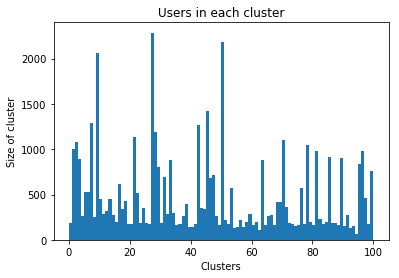

In [160]:
plt.hist(kmeans.labels_, nClusters, [0,nClusters])
plt.title("Users in each cluster")
plt.ylabel("Size of cluster")
plt.xlabel("Clusters")
plt.show()

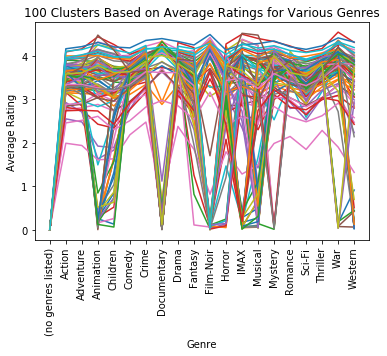

In [161]:
fig, ax = plt.subplots()
ax.plot(kmeans.cluster_centers_.T)
ax.set_xlabel('Genre')
ax.set_ylabel('Average Rating')
ax.set_xticks(range(len(dfNoNan.columns)))
ax.set_xticklabels(dfNoNan.columns)
ax.set_xticklabels(ax.xaxis.get_ticklabels(), rotation=90)
ax.set_title("%d Clusters Based on Average Ratings for Various Genres" %nClusters)

plt.show()

Some people tend to rate everything highly. Other clusters notably do not watch certain genres, such as Documentary or Film-Noir.

In [162]:
dfNoNan.describe()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
count,47117.000000,47117.000000,47117.000000,47117.000000,47117.000000,47117.000000,47117.000000,47117.000000,47117.000000,47117.000000,47117.000000,47117.000000,47117.000000,47117.000000,47117.000000,47117.000000,47117.000000,47117.000000,47117.000000,47117.000000
mean,0.006967,3.485441,3.513823,3.290386,3.282595,3.524217,3.764121,1.922526,3.769502,3.463684,2.181960,3.327554,3.088658,3.138435,3.587765,3.593337,3.440077,3.624974,3.785911,3.059509
std,0.160290,0.521799,0.535808,1.238575,1.013032,0.464236,0.460390,1.980728,0.412215,0.806581,2.015531,1.035955,1.515073,1.339360,0.953686,0.533469,0.644260,0.453065,0.859817,1.453421
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.613636,0.708333,0.000000,1.035581,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.562500,0.000000,0.000000
25%,0.000000,3.176471,3.208333,3.000000,3.000000,3.244048,3.483871,0.000000,3.518438,3.142857,0.000000,3.000000,2.909091,3.000000,3.354167,3.300000,3.109756,3.347619,3.500000,2.857143
50%,0.000000,3.500000,3.545455,3.600000,3.500000,3.544186,3.780488,1.000000,3.787234,3.551724,3.000000,3.500000,3.500000,3.500000,3.750000,3.625000,3.500000,3.637931,3.937500,3.500000
75%,0.000000,3.833333,3.862745,4.000000,3.916667,3.833333,4.076923,4.000000,4.048387,3.966667,4.000000,4.000000,4.000000,4.000000,4.064516,3.940000,3.836364,3.926230,4.250000,4.000000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [163]:
annotatedDf=dfNoNan
annotatedDf["cluster"]=kmeans.labels_

In [164]:
userCluster = annotatedDf["cluster"]

In [165]:
pulpReviews=ratingsForTraining[["userId", "rating"]][ratingsForTraining["movieId"]==mId]
indexedPulpReviews = pulpReviews.set_index("userId")

In [166]:
indexedPulpReviews["cluster"]=userCluster

In [167]:
clusterPulpRatings = indexedPulpReviews[["rating", "cluster"]].groupby("cluster").mean()
clusterPulpRatings.head()

,rating
cluster,
0.0,4.346774
1.0,4.267327
2.0,3.774834
3.0,3.854032
4.0,4.061798


In [168]:
avgPulpRating = indexedPulpReviews["rating"].mean()
avgPulpRating

4.1737058811044845

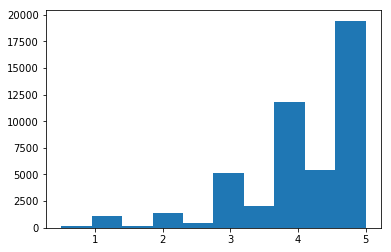

In [169]:
plt.hist(indexedPulpReviews["rating"])
plt.show()

We see that there are some slight differences in the average rating of each cluster compared to the overall rating of this group for Pulp Fiction. Mostly people just like the movie though, and tend to give it 5 star reviews! It's possible that our clusters are not really different with respect to their views on Pulp Fiction, so let's just see what our test data does.

# Step 5: Determine where the test users fit in these clusters, predict that their rating for the movie will be the average of their cluster

In [170]:
TestFilter = ratingsPlus["userId"].isin(testUsers)
ratingsForTest = ratingsPlus[TestFilter]
ratingsForTest.head()

,userId,movieId,rating,title,genres
2,13,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
18,142,2,4.0,Jumanji (1995),Adventure|Children|Fantasy
20,156,2,5.0,Jumanji (1995),Adventure|Children|Fantasy
26,220,2,3.0,Jumanji (1995),Adventure|Children|Fantasy
35,278,2,3.5,Jumanji (1995),Adventure|Children|Fantasy


In [171]:
if compute:
    userDicts = []
    userIds = []
    for thisUser in testUsers:
        thisUserDict = {}
        thisUsersRatings = ratingsForTest[ratingsForTest["userId"] == thisUser]
        for genre in genreList:
            genreFilter = thisUsersRatings["genres"].str.contains(genre)
            avgRating = thisUsersRatings[genreFilter]["rating"].mean()
            thisUserDict[genre]=avgRating
        userDicts.append(thisUserDict)
        userIds.append(thisUser)
    df2 = pd.DataFrame(userDicts, index = userIds)
    df2.to_csv("TestingDf.csv")
else:
    df2= pd.read_csv("TestingDf.csv", index_col = 0)

In [172]:
df2NoNan=df2.replace(np.nan,0)
df2NoNan.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
75429,0.0,3.542857,3.227273,4.200000,3.181818,3.750000,4.136364,5.000000,4.266667,3.333333,0.000000,4.333333,4.000000,4.000000,4.000000,3.884615,3.363636,4.029412,4.166667,3.000000
6624,0.0,2.913953,2.938596,3.600000,3.531250,3.020161,3.235849,2.000000,3.177326,3.074468,1.000000,2.656716,3.083333,3.000000,3.287037,3.074074,2.906452,2.936893,2.907407,3.352941
104782,0.0,3.562500,3.666667,4.333333,4.200000,3.416667,3.333333,0.000000,4.200000,4.333333,0.000000,3.000000,4.666667,4.333333,0.000000,4.571429,3.666667,3.812500,4.666667,4.000000
12073,0.0,3.500000,4.111111,4.250000,4.233333,4.120690,2.423077,0.000000,4.157407,4.000000,0.000000,0.888889,4.166667,4.277778,3.125000,4.351852,3.045455,2.307692,4.166667,4.375000
16075,0.0,3.369822,3.355556,3.636364,3.379310,3.456647,3.694690,3.583333,3.724919,3.418033,3.692308,3.596774,2.833333,3.636364,3.862903,3.500000,3.434783,3.517544,3.858974,3.725000


In [173]:
predictions = kmeans.predict(df2NoNan)

In [174]:
testData = pd.DataFrame()
testData = df2NoNan
testData["cluster"] = predictions#pd.Series(predictions)

In [175]:
testData.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,cluster
75429,0.0,3.542857,3.227273,4.200000,3.181818,3.750000,4.136364,5.000000,4.266667,3.333333,...,4.333333,4.000000,4.000000,4.000000,3.884615,3.363636,4.029412,4.166667,3.000000,63
6624,0.0,2.913953,2.938596,3.600000,3.531250,3.020161,3.235849,2.000000,3.177326,3.074468,...,2.656716,3.083333,3.000000,3.287037,3.074074,2.906452,2.936893,2.907407,3.352941,46
104782,0.0,3.562500,3.666667,4.333333,4.200000,3.416667,3.333333,0.000000,4.200000,4.333333,...,3.000000,4.666667,4.333333,0.000000,4.571429,3.666667,3.812500,4.666667,4.000000,18
12073,0.0,3.500000,4.111111,4.250000,4.233333,4.120690,2.423077,0.000000,4.157407,4.000000,...,0.888889,4.166667,4.277778,3.125000,4.351852,3.045455,2.307692,4.166667,4.375000,37
16075,0.0,3.369822,3.355556,3.636364,3.379310,3.456647,3.694690,3.583333,3.724919,3.418033,...,3.596774,2.833333,3.636364,3.862903,3.500000,3.434783,3.517544,3.858974,3.725000,50


In [176]:
testAssignments = pd.DataFrame({"cluster": testData["cluster"]})
#testAssignments.head()

In [177]:
testAssignments.insert(1,"ratingPredict", testAssignments["cluster"]*0)

In [178]:
for i in range(len(testAssignments)):
    testAssignments["ratingPredict"].iloc[i]=clusterPulpRatings.loc[testAssignments["cluster"].iloc[i]]["rating"]

/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:179: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [179]:
testAssignments["userId"]=testAssignments.index
testAssignments.head()

,cluster,ratingPredict,userId
75429,63,4.151144,75429
6624,46,3.463693,6624
104782,18,3.813312,104782
12073,37,3.549724,12073
16075,50,4.292353,16075


# Step 6: Compare these predicted ratings vs. their true rating to the default prediction vs. true rating (the default prediction is that all users would rate it as the total average rating for that movie)

In [180]:
TestPulpReviews=ratingsForTest[["userId", "rating"]][ratingsForTest["movieId"]==mId]

In [181]:
testPredictTrue = testAssignments.merge(TestPulpReviews, on="userId")

In [182]:
testPredictTrue["defaultPredict"]=avgPulpRating
testPredictTrue.head()

,cluster,ratingPredict,userId,rating,defaultPredict
0,46,3.463693,99243,3.0,4.173706
1,64,4.083333,109454,5.0,4.173706
2,28,4.053790,41160,4.5,4.173706
3,2,3.774834,42843,1.0,4.173706
4,70,4.705311,4156,5.0,4.173706


Calculate the root mean squared error:

In [183]:
predictScore = np.sqrt(((testPredictTrue["ratingPredict"]-testPredictTrue["rating"])**2).mean())
print(predictScore)

0.9520186432


In [184]:
defaultScore = np.sqrt(((testPredictTrue["rating"]-testPredictTrue["defaultPredict"])**2).mean())
print(defaultScore)

0.981877660684


In [185]:
print("% improvement: ",(defaultScore-predictScore)/defaultScore*100)

% improvement:  3.0410119997


There is a slight improvement in our ability to predict the user's rating for "Pulp Fiction" over the default prediction.

In [186]:
clusterTestPulpRatings = testPredictTrue[["rating", "cluster"]].groupby("cluster").mean()

In [187]:
TestPulpReviews=ratingsForTest[["userId", "rating"]][ratingsForTest["movieId"]==mId]

   training ratings  test ratings
0          4.346774      4.326087
1          4.267327      4.185039
2          3.774834      3.774306
3          3.854032      3.810924
4          4.061798      3.544118
                  training ratings  test ratings
training ratings          1.000000      0.775352
test ratings              0.775352      1.000000


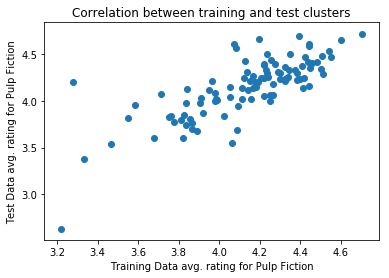

In [188]:
df4 = pd.DataFrame({})
df4["training ratings"] = clusterPulpRatings
df4["test ratings"] = clusterTestPulpRatings
print(df4.head())
print(df4.corr())
plt.scatter(clusterPulpRatings, clusterTestPulpRatings)
plt.title("Correlation between training and test clusters")
plt.xlabel("Training Data avg. rating for Pulp Fiction")
plt.ylabel("Test Data avg. rating for Pulp Fiction")
plt.show()

The average rating for Pulp Fiction in each group is well correlated between the training and the test data.

In [190]:
testPredictTrue.describe()

,cluster,ratingPredict,userId,rating,defaultPredict
count,6141.000000,6141.000000,6141.000000,6141.000000,6.141000e+03
mean,44.833903,4.169307,69246.877870,4.170901,4.173706e+00
std,29.809134,0.276416,39887.720508,0.981954,2.753577e-13
min,0.000000,3.220395,18.000000,0.500000,4.173706e+00
25%,21.000000,3.983755,35085.000000,4.000000,4.173706e+00
50%,43.000000,4.178105,68240.000000,4.500000,4.173706e+00
75%,70.000000,4.374656,103903.000000,5.000000,4.173706e+00
max,99.000000,4.705311,138473.000000,5.000000,4.173706e+00
